# Transferencia de Aprendizaje (Transfer Learning)

## 1. Introducción Teórica

La Transferencia de Aprendizaje es una técnica fundamental en Deep Learning que nos permite aprovechar
modelos pre-entrenados en grandes conjuntos de datos para aplicarlos a nuestros problemas específicos.

Ventajas principales:
- Ahorro significativo de tiempo y recursos computacionales
- Mejor rendimiento con conjuntos de datos pequeños
- No requiere partir desde cero en el entrenamiento

En este cuaderno, vamos a clasificar imágenes de babuinos y jirafas utilizando MobileNetV2,
una red neuronal pre-entrenada en el dataset ImageNet.


## 2. Preparación del Dataset
# Descomprimimos las imágenes de ejemplo

Primero, vamos a preparar nuestro conjunto de datos local.
Descomprimimos los archivos zip que contienen las imágenes de babuinos y jirafas.

In [1]:
#!unzip perros.zip -d perro
!unzip person-front.zip -d person


Archive:  person-front.zip
   creating: person/person-front/
  inflating: person/person-front/image (5).jpeg  
  inflating: person/person-front/image (6).jpeg  
  inflating: person/person-front/image (7).jpeg  
  inflating: person/person-front/image (8).jpeg  
  inflating: person/person-front/image (9).jpeg  
  inflating: person/person-front/image (10).jpeg  
  inflating: person/person-front/image (11).jpeg  
  inflating: person/person-front/image (12).jpeg  
  inflating: person/person-front/image (13).jpeg  
  inflating: person/person-front/image (14).jpeg  
  inflating: person/person-front/image (15).jpeg  
  inflating: person/person-front/image (16).jpeg  
  inflating: person/person-front/image (17).jpeg  
  inflating: person/person-front/image (21).jpeg  
  inflating: person/person-front/image (22).jpeg  
  inflating: person/person-front/image (24).jpeg  
  inflating: person/person-front/image (25).jpeg  
  inflating: person/person-front/image (26).jpeg  
  inflating: person/person

In [2]:
%%capture
!unzip person-with-mask.zip -d person-with-mask

### Creamos un dataset con las imagenes

In [3]:
!rm -rf person-front.zip #perros.zip
!rm -rf person-with-mask.zip #gatos.zip

In [4]:
!mkdir dataset
!cp -r person dataset/person #perro dataset/perro
!cp -r person-with-mask dataset/person-with-mask #gato dataset/gato

Reiniciar sesión luego de iniciar

In [5]:
%%capture
!pip install tensorflow==2.15

## 3. Aumento de Datos (Data Augmentation)

El aumento de datos es una técnica crucial que nos permite:
- Aumentar artificialmente nuestro conjunto de datos
- Mejorar la generalización del modelo
- Evitar el sobreajuste (overfitting)

Aplicaremos las siguientes transformaciones:
- Reescalado de píxeles a valores entre 0 y 1
- Rotaciones aleatorias (±10 grados)
- Desplazamientos horizontales y verticales (±15%)
- Deformaciones (shear)
- Zoom variable (entre 70% y 130%)


In [1]:
#Aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255, # normaliza
    rotation_range = 10, # rota aleatoriamente hasta 10 grados
    width_shift_range=0.15, # desplaza hasta un 15%
    height_shift_range = 0.15, #ancho y alto
    shear_range = 5, # Aplica una transformación de cizallamiento (shear) aleatoria hasta 5 grados
    zoom_range = [0.7, 1.3], # Aplica un zoom aleatorio entre el 70% y el 130% de la imagen original
    validation_split = 0.2 # Reserva el 20% de los datos para validación
)

data_gen_entrenamiento = datagen.flow_from_directory("/content/dataset",
                                                     target_size=(224,224), # redimensiona
                                                     batch_size=32, # nro de imagenes a procesar
                                                     shuffle=True, # mezcla las imagenes
                                                     subset="training")

data_gen_pruebas = datagen.flow_from_directory("/content/dataset",
                                                     target_size=(224,224),
                                                     batch_size=32, shuffle=True,
                                                     subset="validation")

Found 132 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


Una transformación de cizallamiento (shear) en imágenes implica distorsionar la imagen desplazando píxeles de manera proporcional a su distancia de un eje de referencia, creando un efecto de "inclinación" o "sesgo" que mantiene el área total pero altera la forma.

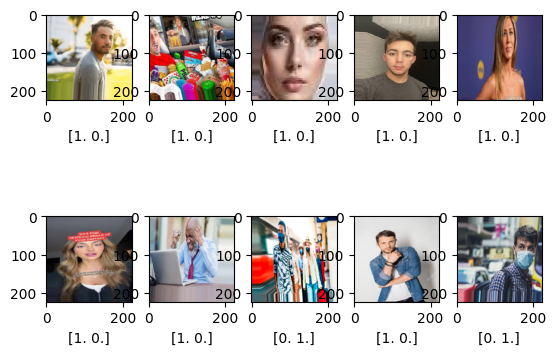

In [2]:
import matplotlib.pyplot as plt

for imagenes, etiquetas in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imagenes[i])
    plt.xlabel(str(etiquetas[i]))

  break
plt.show()

##Construcción del Modelo con Transfer Learning

Utilizaremos MobileNetV2 como modelo base, que:
- Es una red neuronal eficiente diseñada para dispositivos móviles
- Está pre-entrenada en más de 1 millón de imágenes de ImageNet
- Tiene una excelente relación rendimiento/recursos


Probaremos con dos formas de predicciones.
La primer

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Cargar MobileNetV2 desde TensorFlow Hub
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))
mobilenetv2.trainable = False

# Construir el modelo
model = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
EPOCHS = 20
history = model.fit(
    data_gen_entrenamiento,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=data_gen_pruebas
)


In [3]:
import tensorflow as tf
import tensorflow_hub as hub

url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))

#Congelar las capas
mobilenetv2.trainable = False

#Construir el modelo funcional
input_layer = tf.keras.Input(shape=(224, 224, 3))
x = mobilenetv2(input_layer)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Agregar una capa de pooling
output_layer = tf.keras.layers.Dense(2, activation="softmax")(x)
modelo = tf.keras.Model(inputs=input_layer, outputs=output_layer)

modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


## Entrenamiento del Modelo

Entrenamos el modelo durante 20 épocas, monitoreando tanto el rendimiento
en entrenamiento como en validación.


In [4]:
EPOCAS = 20
entrenamiento = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/20
5/5 [==============================] - 17s 2s/step - loss: 0.7188 - accuracy: 0.6136 - val_loss: 0.6055 - val_accuracy: 0.6250
Epoch 2/20
5/5 [==============================] - 8s 1s/step - loss: 0.4714 - accuracy: 0.7652 - val_loss: 0.4010 - val_accuracy: 0.7812
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 0.3584 - accuracy: 0.8333 - val_loss: 0.2661 - val_accuracy: 0.9375
Epoch 4/20
5/5 [==============================] - 9s 2s/step - loss: 0.2386 - accuracy: 0.9394 - val_loss: 0.2289 - val_accuracy: 0.8750
Epoch 5/20
5/5 [==============================] - 8s 1s/step - loss: 0.1729 - accuracy: 0.9470 - val_loss: 0.3109 - val_accuracy: 0.8125
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 0.1413 - accuracy: 0.9697 - val_loss: 0.2719 - val_accuracy: 0.8438
Epoch 7/20
5/5 [==============================] - 9s 2s/step - loss: 0.1370 - accuracy: 0.9621 - val_loss: 0.2392 - val_accuracy: 0.9375
Epoch 8/20
5/5 [========================

## Función de Predicción

Creamos una función para realizar predicciones sobre nuevas imágenes.
Esta función:
1. Carga la imagen
2. La preprocesa al formato correcto
3. Realiza la predicción usando nuestro modelo


In [5]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt  # Para visualización

def visualizar_imagen(im, titulo=None, gama=None):
  plt.figure(figsize=(8, 6))
  plt.imshow(im, cmap=gama)
  plt.axis('off')  # Ocultar ejes
  plt.title(titulo)
  plt.show()

def categorizar(ruta):
  img = Image.open(ruta)
  img = img.convert("RGB")
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224, 224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  visualizar_imagen(img)
  return np.argmax(prediccion[0], axis=-1)



## Pruebas del Modelo

Probamos el modelo con algunas imágenes de ejemplo:
0 = Sin Barbijo
1 = Con Barbijo



1/1 [==============================] - 1s 625ms/step


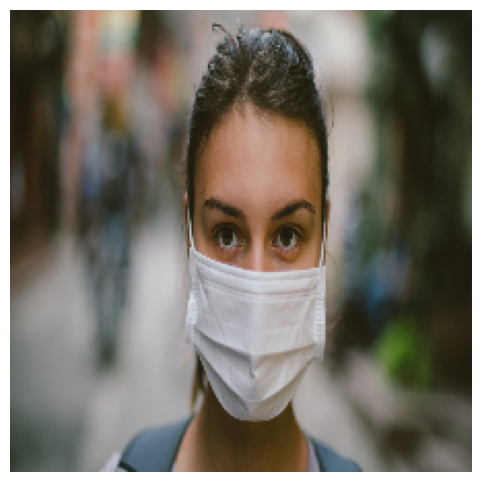

##################################################
Predicción:  1


In [6]:
#  ruta = "/content/gato/gatos/05f18bab-8bb9-4cf3-9e48-73452526cf95_16-9-discover-aspect-ratio_default_0.jpg"
ruta = "girl-mask.jpg"
prediccion = categorizar(ruta)
print("#"*50 + "\n" + "Predicción: ",prediccion)


la imagen si corresponde a un gato

1/1 [==============================] - 0s 49ms/step


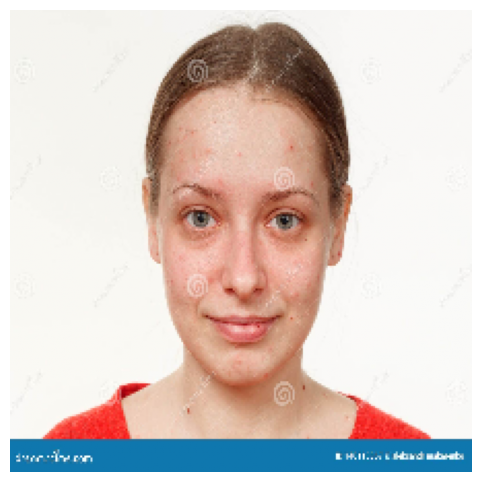

0
##################################################
Predicción:  0


In [7]:
#ruta = "dog-wind.jpg"
ruta= "girl-without-mask.jpg"
prediccion = categorizar(ruta)
print(prediccion)
print("#"*50 + "\n" + "Predicción: ",prediccion)


1/1 [==============================] - 0s 46ms/step


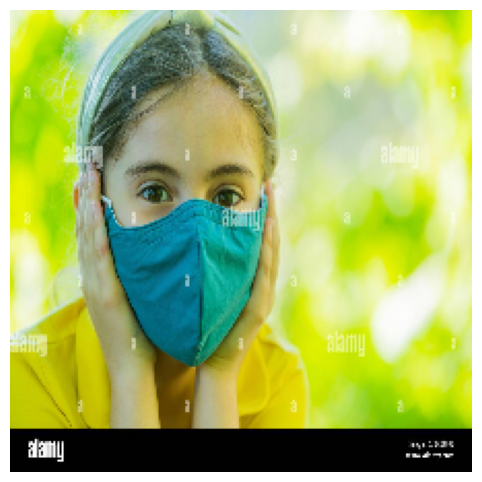

##################################################
Predicción:  1


In [8]:
#ruta = "dog-halloween.jpg"
ruta = "kid-mask.jpg"
prediccion = categorizar(ruta)
print("#"*50 + "\n" + "Predicción: ",prediccion)

1/1 [==============================] - 0s 51ms/step


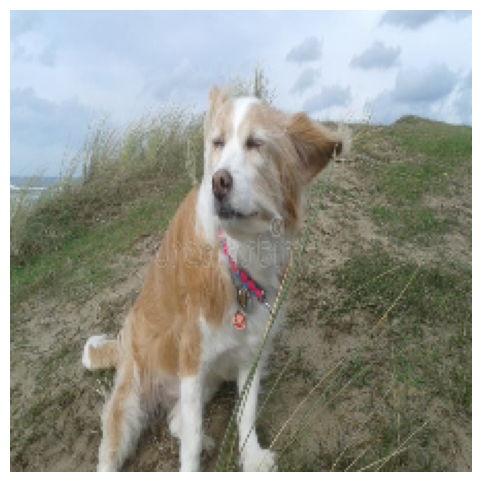

##################################################
Predicción:  1


In [10]:
ruta = "dog-wind.jpg"
prediccion = categorizar(ruta)
print("#"*50 + "\n" + "Predicción: ",prediccion)

1/1 [==============================] - 0s 48ms/step


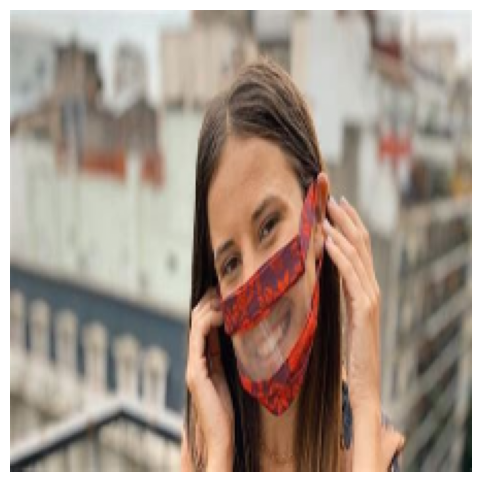

##################################################
Predicción:  1


In [9]:
ruta = "girl-mask-trans.jpeg"
prediccion = categorizar(ruta)
print("#"*50 + "\n" + "Predicción: ",prediccion)

# Apropiación del ejercicio dado en clase
El ejecicio constaba de dos carpetas con imagenes de gatos y perros y entrenamos el modelo, luego lo pusimos a prueba.
Para la apropiación decidi usar imagenes de personas con barbijo y sin. De este modo podriamos utilizarlo en regiones en las que sea necesario el uso y que sea de caracter obligatorio.

El modelo solo toma dos valores, en caso de utlizar una imagen que no debe ser tenida en cuenta como la de un perro, sigue dando una predicción.